In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import prim
import seaborn as sns

In [3]:
from newshiftedColorMap import *

ImportError: No module named 'newshiftedColorMap'

In [ ]:
orig_cmap = matplotlib.cm.coolwarm
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=0.75, name='shifted')
shrunk_cmap = shiftedColorMap(orig_cmap, start=0.15, midpoint=0.75, stop=0.85, name='shrunk')


In [2]:
%matplotlib inline

In [3]:
sns.set_context("notebook",rc={"font.size": 18})
sns.set_style("whitegrid")

In [4]:
inputs=pd.read_csv("uncertainties_2options_round2.csv")
outputs=pd.read_csv("results_2options_round2.csv")

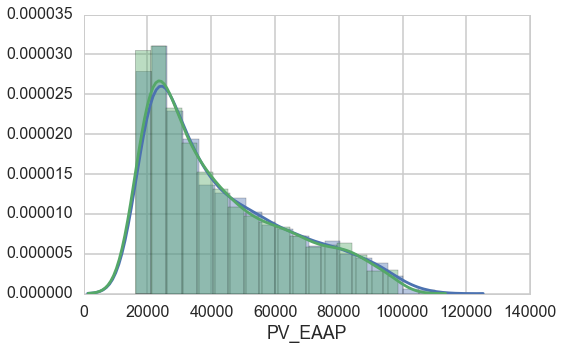

In [9]:
fig = plt.figure(figsize=(8,5))
sns.distplot(outputs[inputs.policy=="option 7"].PV_EAAP)
sns.distplot(outputs[inputs.policy=="option 8"].PV_EAAP)

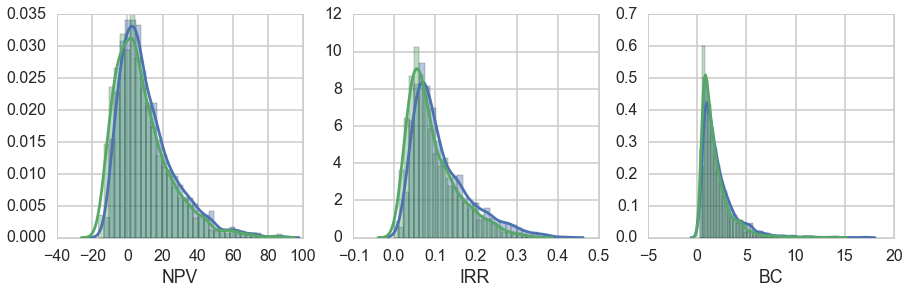

In [10]:
fig = plt.figure(figsize=(15,4))
plt.subplot(131)
sns.distplot(outputs[inputs.policy=="option 7"].NPV)
sns.distplot(outputs[inputs.policy=="option 8"].NPV)
plt.subplot(132)
sns.distplot(outputs[inputs.policy=="option 7"].loc[outputs.IRR>0,'IRR'])
sns.distplot(outputs[inputs.policy=="option 8"].loc[outputs.IRR>0,'IRR'])
plt.subplot(133)
sns.distplot(outputs[inputs.policy=="option 7"].BC)
sns.distplot(outputs[inputs.policy=="option 8"].BC)

In [17]:
%matplotlib inline

# Here I am starting the scenario discovery process. First looking for conditions for positive NPV for option 7 then option 8.

The first graph shows the trade-offs between coverage and density for finding the combination of factors that best explain positive NPV

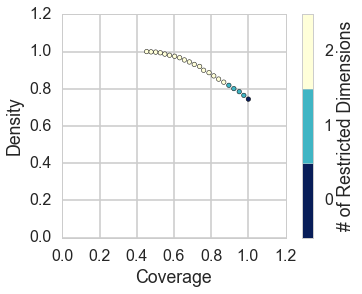

In [18]:
p = prim.Prim(inputs, outputs[inputs.policy=="option 7"].NPV>0, threshold=0.5, threshold_type=">")

box = p.find_box()
box.show_tradeoff()

plt.show()

### I select box 8 wich is a good compromise

In [21]:
box.select(8)

### This shows that the factors that explain a positive NPV are the discount rate (lower than 10%) and COSTAG (increase lower than 168%)

In [22]:
print(box)

Box 1 [Peeling Trajectory 8]
    Stats
        Coverage: 0.788449
        Density:  0.886707
        Mass:     0.662000
        Res Dim:  2.000000
        Mean:     0.886707
    Limits
                     min       max     qp values
        D       0.000018  0.097683  1.747387e-12
        COSTAG  0.300642  1.684486  7.509614e-12


### This a visualisation of the same thing

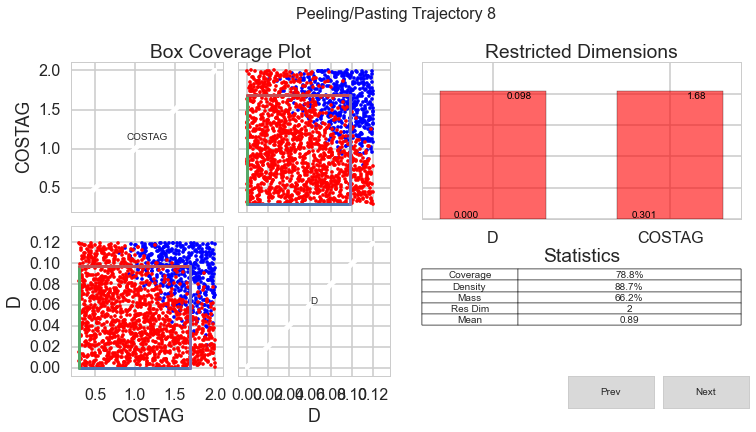

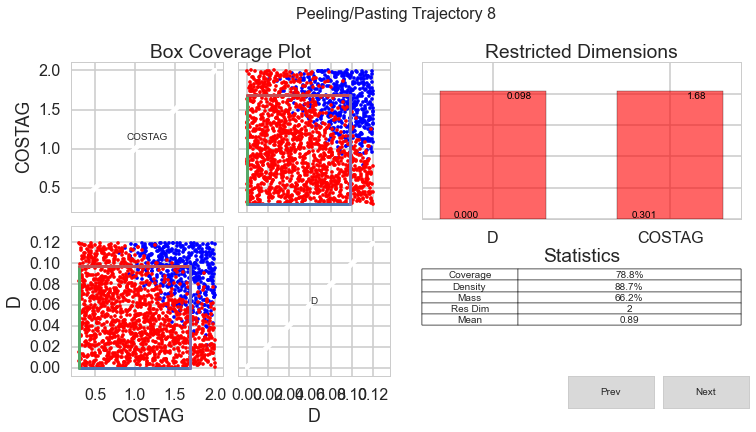

In [23]:
box.show_details()

### I repeat everything for option 8

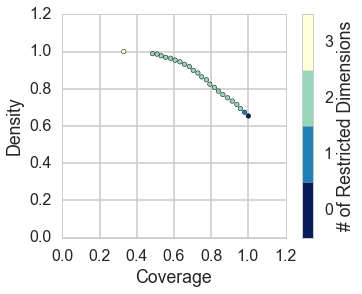

In [25]:
p = prim.Prim(inputs, outputs[inputs.policy=="option 8"].NPV>0, threshold=0.5, threshold_type=">")

box = p.find_box()
box.show_tradeoff()

plt.show()

In [26]:
box.select(10)
print(box)

Box 1 [Peeling Trajectory 10]
    Stats
        Coverage: 0.774465
        Density:  0.848409
        Mass:     0.597000
        Res Dim:  2.000000
        Mean:     0.848409
    Limits
                     min       max     qp values
        D       0.000018  0.087862  3.656973e-22
        COSTAG  0.300642  1.681493  5.570265e-11


### The conditions are nearly the same for NPV>0 for option 7 and 8. For option 8 the condition on the discount rate is lower than 9%

In [5]:
b = pd.concat([inputs,outputs],axis=1)

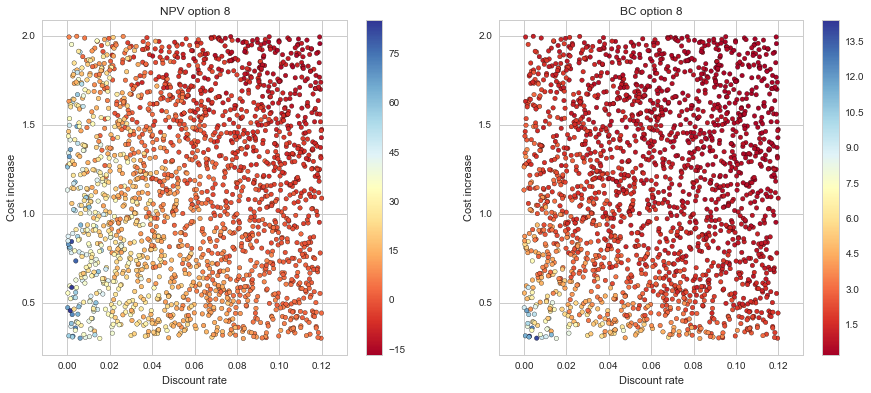

In [15]:
fig = plt.figure(figsize=(15,6))

cm = plt.cm.get_cmap('RdYlBu')
plt.subplot(121)
sc = plt.scatter(inputs[inputs.policy=="option 8"].D,inputs[inputs.policy=="option 8"].COSTAG,c=outputs[inputs.policy=="option 8"].NPV,cmap=cm)
plt.colorbar(sc)
plt.axis('tight')
plt.xlabel("Discount rate")
plt.ylabel("Cost increase")
plt.title("NPV option 8")

plt.subplot(122)
sc = plt.scatter(inputs[inputs.policy=="option 8"].D,inputs[inputs.policy=="option 8"].COSTAG,c=outputs[inputs.policy=="option 8"].BC,cmap=cm)
plt.colorbar(sc)
plt.axis('tight')
plt.xlabel("Discount rate")
plt.ylabel("Cost increase")
plt.title("BC option 8")

### Now I look at more stringent conditions, I want NPV>0 and BC ratio>2

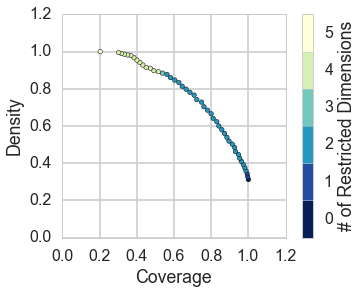

In [28]:
p = prim.Prim(inputs, (outputs[inputs.policy=="option 8"].NPV>0)&(outputs[inputs.policy=="option 8"].BC>2), threshold=0.5, threshold_type=">")

box = p.find_box()
box.show_tradeoff()

plt.show()

In [30]:
box.select(25)
print(box)

Box 1 [Peeling Trajectory 25]
    Stats
        Coverage: 0.685897
        Density:  0.781022
        Mass:     0.274000
        Res Dim:  2.000000
        Mean:     0.781022
    Limits
                     min       max     qp values
        COSTAG  0.300642  1.003065  8.570887e-63
        D       0.000018  0.078535  2.529886e-21


### If we add the condition on BC ratio>2, the conditions become COSTAG<100% and discount rate lower than 8%

## Now I am looking to explain the difference between option 7 and option 8

### I calculate option 8 - option 7 for each output

In [33]:
c = b.groupby(['Adgr', 'AVAWO', 'COSTAG', 'D', 'INTANGD', 'ITD', 'Adpopgr', 'POPwo','SLRindex']).apply(lambda x:x[['PV_EAAP', 'IRR', 'BC', 'NPV', 'PV_EAAP_C']].diff())

In [36]:
c.dropna(inplace=True)

### this shows that the only variable that can be better under option 8 than option 7 is the number of affected people PV_EAAP

In [37]:
c.describe()

,PV_EAAP,IRR,BC,NPV,PV_EAAP_C
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,-1048.822216,-0.021100,-0.366319,-2.938417,-633.982744
std,2801.404963,0.009805,0.300828,1.159201,527.667411
min,-17062.650049,-0.070219,-2.715716,-6.956000,-6465.157718
25%,-2024.351198,-0.024556,-0.458039,-3.714600,-775.335414
50%,-793.150540,-0.017295,-0.275789,-2.907250,-476.034390
75%,9.319240,-0.014420,-0.165962,-2.021650,-295.705000
max,11013.822577,-0.010807,-0.054947,-0.656800,-98.351288


In [39]:
sum(c.PV_EAAP>0)/len(c)

0.252

In 25% of all scenarios option 8 protects more people than option 7

### now we look for the conditions under which option 8 protects more people 

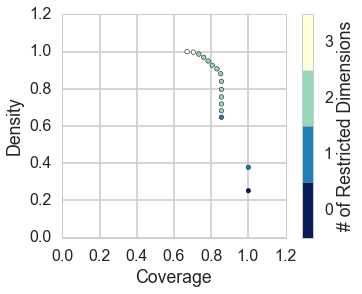

In [41]:
p = prim.Prim(inputs.iloc[0:2000,:], c.PV_EAAP>0, threshold=0.5, threshold_type=">")

box = p.find_box()
box.show_tradeoff()

plt.show()

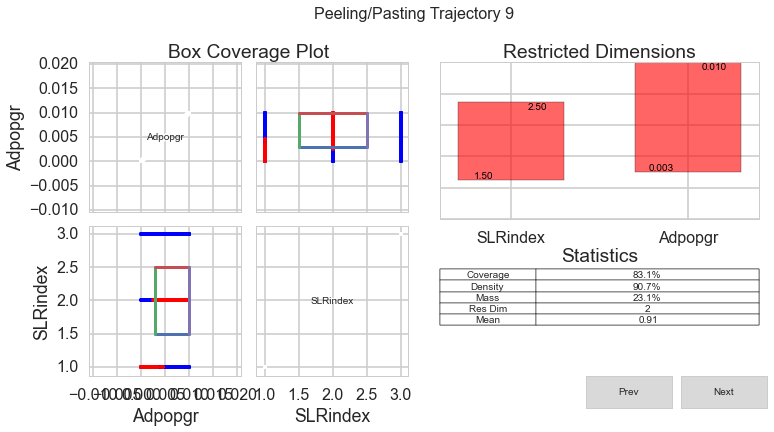

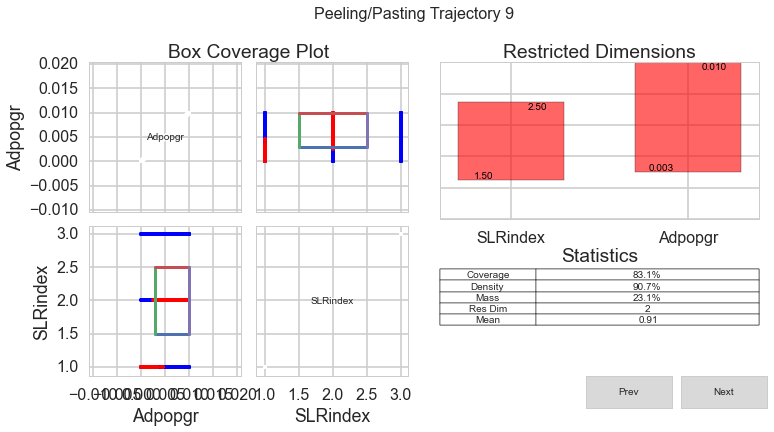

In [42]:
box.select(9)
box.show_details()

### option 8 is better in scenarios with medium sea level rise (index 2 is RCP4.5) and in which the population with protection increases more than 0.3% points faster than without protection (Adpopgr > 0.003)

In [44]:
print(box)

Box 1 [Peeling Trajectory 9]
    Stats
        Coverage: 0.831349
        Density:  0.906926
        Mass:     0.231000
        Res Dim:  2.000000
        Mean:     0.906926
    Limits
                       min       max      qp values
        SLRindex  1.500000  2.500000  8.201400e-162
        Adpopgr   0.002985  0.009997   2.338037e-38


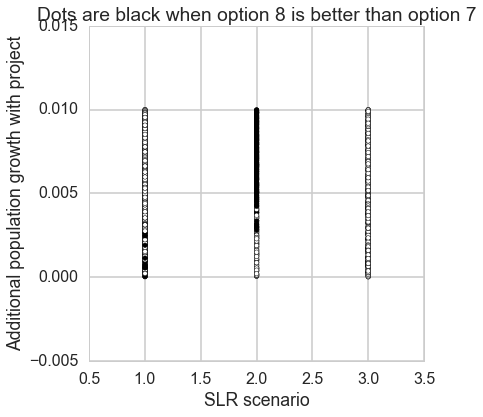

In [66]:
fig = plt.figure(figsize=(6,6))

plt.scatter(inputs.iloc[0:2000,:].SLRindex,inputs.iloc[0:2000,:].Adpopgr,c=c.PV_EAAP>0)
plt.ylim([-0.005,0.015])
plt.xlabel("SLR scenario")
plt.ylabel("Additional population growth with project")
plt.title("Dots are black when option 8 is better than option 7")